# Imports and specific functions for multiple bioleaching analysis

In [2]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.path import Path
from matplotlib.colors import ListedColormap
import matplotlib.ticker as mtick
import copy
import tol_colors as tc
import matplotlib as mpl
from matplotlib.colors import from_levels_and_colors

import cobra
#import cobra.test
from cobra import Metabolite, Reaction, Model
from cobra.util.array import create_stoichiometric_matrix
from cobra.util.solver import linear_reaction_coefficients
from cobra.flux_analysis import flux_variability_analysis
from benpy import vlpProblem
from benpy import solve as bensolve
from scipy.sparse import lil_matrix
from scipy.spatial import Delaunay
from scipy.spatial import distance

from functools import reduce 

import scipy.io as sio
from cobra.io.mat import _cell 
from collections import OrderedDict

from operator import itemgetter

from multiple_ecosystem import Ecosystem
from eco_utils import *

from sklearn.cluster import DBSCAN, OPTICS,SpectralClustering, AffinityPropagation

from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy


In [20]:
def pre_plot_clusters(model, parent_cmap, df_ref=None):
    #computes data to plot clusters
    #ax = ax or plt.gca()

    cmaplist = (
            'sunset_discrete', 'sunset', 'BuRd_discrete', 'BuRd',
            'PRGn_discrete', 'PRGn', 'YlOrBr_discrete', 'YlOrBr', 'WhOrBr',
            'iridescent', 'rainbow_PuRd', 'rainbow_PuBr', 'rainbow_WhRd',
            'rainbow_WhBr', 'rainbow_discrete')

    csetlist = ('bright', 'high-contrast', 'vibrant', 'muted', 'medium-contrast', 'light')
    free_member_prefixes = model.prefixes
    free_member_indexes = [0,1]
    full_slice_indexes = np.arange(len(model.points))

    feasible_indexes    = np.where(model.feasible_points)[0]
    feasible_points     = model.points[feasible_indexes]
    feasible_pfractions = model.pfractions[feasible_indexes]

    slice_indexes    = np.isin(feasible_indexes, full_slice_indexes)
    slice_points     = feasible_points[slice_indexes,:][:,free_member_indexes]  

    slice_pfractions = feasible_pfractions

    slice_colors = model.clusters[slice_indexes] #slice points clusters
    if df_ref is None:
        k = model.k
    else:
        k = len(df_ref.columns)+1
    color_labels = ['']+['c'+ str(x+1) for x in range(k)] 

    pfrac = model.pfractions

    #myfig = plt.figure(figsize=figsize)
    if parent_cmap in cmaplist:
        cmap1 = tc.tol_cmap(parent_cmap)
    elif parent_cmap in csetlist:
        cmap1 = ListedColormap(tc.tol_cset(parent_cmap))
    else:
        #cmap1=plt.get_cmap(parent_cmap,k)
        cmap1 = plt.get_cmap(parent_cmap)

    cmap1.set_bad('k')
    #np.random.shuffle(cmap1.colors) #colors are not random
    vmin=0.5
    vmax =k + 0.5 



    x = slice_points[:,0]
    y = slice_points[:,1]

    s = 20
    delta_y = np.unique(y)[1]
    s = s*(1000*delta_y)
    #print(1000*delta_y)
    cmap = cmap1
    c = slice_colors

    return(x, y, c, cmap1, vmin, vmax, s)

def trans_cluster_colors(model2, df_clusters_key):
    reactions_key = df_clusters_key.index
    #model2 = copy.deepcopy(master_cases[case])
    df_clusters2 = model2.get_cluster_reaction_values(thr=0.8, changing= True)
    reactions_key2 = df_clusters2.index #remove row 

    common_reactions = set(reactions_key).intersection(set(reactions_key2))

    compare_master = df_clusters_key.loc[list(common_reactions)]
    compare_2 = df_clusters2.loc[list(common_reactions)]

    compare_scores = np.zeros((len(compare_master.columns), len(compare_2.columns)))
    for i,c in enumerate(compare_master.columns):
        for j,c2 in enumerate(compare_2.columns):
            compare_scores[i][j] = sum(compare_master[c].eq(compare_2[c2]))

    change_clusters = dict() #change_clusters[c2] = main_cluster
    for s in np.unique(np.sort(-compare_scores, axis=None)):
        x,y = np.where(compare_scores==-s)
        for i,x in enumerate(x):
            if len(change_clusters) == len(compare_2.columns):
                break
            else:
                c2 = int(compare_2.columns[y[i]].replace('c',''))
                corg = int(compare_master.columns[x].replace('c',''))
                if c2 in change_clusters.keys():
                    pass
                else:
                    change_clusters[c2] = corg 

    new_clusters = np.array([change_clusters[c] for c in model2.clusters])
    return(new_clusters)

def paint_same_cluster(model2, df_clusters_key):
    reactions_key = df_clusters_key.index
    clusters_key = df_clusters_key.columns
    #print(clusters_key)

    df_clusters2 = model2.get_cluster_reaction_values(thr=threshold, changing= True)
    reactions_key2 = df_clusters2.index #remove row 

    common_reactions = set(reactions_key).intersection(set(reactions_key2))

    compare_master = df_clusters_key.loc[list(common_reactions)]
    compare_2 = df_clusters2.loc[list(common_reactions)]

    change_clusters = dict()
    for cm in compare_master.columns: #there has to be a better way
        for c in compare_2.columns:
            #check for nans
            c2_col = compare_2[c]
            not_nan_2 = set(c2_col[c2_col.notna()].index)
            cmaster_col = compare_master[cm]
            not_nan_m = set(cmaster_col[cmaster_col.notna()].index)

            notna_rxns = not_nan_2.intersection(not_nan_m)
            newcomp2 = compare_2[c].loc[list(notna_rxns)]
            newcompm = compare_master[cm].loc[list(notna_rxns)]
            #clusters

            comp = newcomp2 == newcompm
            cdict = int(c.replace('c',''))

            if comp.all() and cdict not in change_clusters.keys():

                cmdict = int(cm.replace('c',''))
                change_clusters[cdict] = cmdict

            elif comp.all() and c in change_clusters.keys():
                print(str(c)+' already in dict!')

    for c in model2.clusters:
        if c not in change_clusters.keys():

            change_clusters[c] = len(df_clusters_key.columns)+1
            #associate cluster to new cluster in df
            df_clusters_key['c'+str(len(df_clusters_key.columns)+1)] = df_clusters2['c'+str(c)]



    new_clusters = np.array([change_clusters[c] for c in model2.clusters])
    return(new_clusters, df_clusters_key)

def pre_plot_reaction(model, rxnID, parent_cmap):
    c=model.qual_vector_df[rxnID]
    cmaplist = (
            'sunset_discrete', 'sunset', 'BuRd_discrete', 'BuRd',
            'PRGn_discrete', 'PRGn', 'YlOrBr_discrete', 'YlOrBr', 'WhOrBr',
            'iridescent', 'rainbow_PuRd', 'rainbow_PuBr', 'rainbow_WhRd',
            'rainbow_WhBr', 'rainbow_discrete')

    csetlist = ('bright', 'high-contrast', 'vibrant', 'muted', 'medium-contrast', 'light')

    free_member_prefixes = model.prefixes
    free_member_indexes = [0,1]
    full_slice_indexes = np.arange(len(model.points)) 
    full_slice_points = model.points[full_slice_indexes,:][:,free_member_indexes]

    x = model.points[c.index,0]
    y = model.points[c.index,1]

    if parent_cmap in cmaplist:
        cmap1 = cmap = tc.tol_cmap(parent_cmap)
    elif parent_cmap in csetlist:
        cmap1 = ListedColormap(tc.tol_cset(parent_cmap))
    else:
        cmap1 = plt.get_cmap(parent_cmap, 8)

    vmin = -3
    vmax = 4

    return(x, y, c, cmap1, vmin, vmax)   

def filter_cases(simulations, alpha=[], obj=[], cons=[], energy=[], sub_combs=[], flag=[]):
    #Filters cases based on 
    alpha = params['alpha']
    obj = params['obj']
    cons = params['cons']
    energy = params['energy']
    sub_combs = params['sub_combs']
    flag = params['flag']
    #if objective empty, add other objectives to flag list
    #total objectives from simulations loaded based on objective column in dataframe
    available_obj = set(simulations['Objective'].dropna())
    if len(obj)==0:
        for obj in available_obj:
            flag.append('_'+obj)


    energy_lvls = ['high', 'medium', 'low']
    subcom_lvls = [[x, round(1-x,2)] for x in [1, 0.9, 0.75, 0.6, 0.5, 0.4, 0.25, 0.1, 0]]
    sub_comb = list()
    if len(energy)==0:
        for e in energy_lvls:
            if len(sub_combs)>0:
                for s in sub_combs:
                    sub_comb.append(str(s[0])+'_Fe_'+e+'_'+str(s[1])+'_S_'+e)
            else:
                for s in subcom_lvls:
                    sub_comb.append(str(s[0])+'_Fe_'+e+'_'+str(s[1])+'_S_'+e)            
    else:
        for e in energy:
            e = e.lower()
            if len(sub_combs)>0:
                for s in sub_combs: 
                    sub_comb.append(str(s[0])+'_Fe_'+e+'_'+str(s[1])+'_S_'+e)
            else:
                for s in subcom_lvls:
                    sub_comb.append(str(s[0])+'_Fe_'+e+'_'+str(s[1])+'_S_'+e)

    #Filter cases
    filtered_cases = set()

    filtered_list = []

    if len(alpha) > 0:
        filt_a = set()
        for a in alpha:
            a = str(a)
            a = a.replace('.',',')
            #print(a)
            case = simulations[simulations['Alpha'].replace(',','.')==a]['Filename']
            for c in case:
                #print(c)
                filt_a.add(c)
        filtered_list.append(filt_a)

    if len(cons) >0:
        filt_c = set()
        for c in cons:
            case = simulations[simulations['input constraint']==c]['Filename']
            for c in case:
                filt_c.add(c)
        filtered_list.append(filt_c)

    if len(energy)>0:
        filt_e = set()
        for e in energy:
            case = simulations[simulations['Energy level']==e]['Filename']
            for c in case:
                filt_e.add(c)
        filtered_list.append(filt_e)

    if len(sub_comb)>0:
        filt_s = set()
        for s in sub_comb:
            case = simulations[simulations['Substrate combination']==s]['Filename']

            for c in case:
                filt_s.add(c)
        filtered_list.append(filt_s)

    if len(obj)>0:
        #print(obj)
        filt_o = set()
        for o in obj:
            case = simulations[simulations['Objective']==o]['Filename']
            for c in case:
                #print(c)
                filt_o.add(c)
        filtered_list.append(filt_o)

    non_empties = [x for x in filtered_list if x] #unpacking elements for intersection comparison


    filtered_cases = set.intersection(*non_empties)
    filtered_cases = list(filtered_cases)


    flag_cases = set()
    if len(flag)>0:
        for f in flag:
            #flag works as a substring of the case that has to ve avoided, it could be a composition or an objective
            #print(f)
            for c in filtered_cases:
                #print(c)
                if f in c:
                    #print(c)
                    flag_cases.add(c)


    filtered_cases = list(set(filtered_cases) - flag_cases)
    #filtered_cases = [f.replace(',','.') for f in filtered_cases]
    #remove . only in alpha

    filtered_cases = [f.replace('_a0_','_a00_') for f in filtered_cases]
    filtered_cases = [f.replace('_a0.','_a0') for f in filtered_cases]
    filtered_cases = [f.replace('_a0,','_a0') for f in filtered_cases]
    filtered_cases = [f.replace('_a1_','_a10_') for f in filtered_cases]

    #sort by alpha and Fe

    change_order = [simulations[simulations['Filename']==c]['Alpha'].iloc[0].replace(',','.') for c in filtered_cases]

    sorted_filtered = [x for _, x in sorted(zip(change_order, filtered_cases), reverse=False)]

    change_order = [float(simulations[simulations['Filename']==c]['Input Fe'].iloc[0].replace(',','.')) for c in filtered_cases]
    sorted_filtered = [x for _, x in sorted(zip(change_order, filtered_cases), reverse=False)]

    filtered_cases = sorted_filtered
    return(filtered_cases)

def load_cases(filtered_cases, params):
    #load files
    k = params['k']
    master_cases = dict()

    for case in filtered_cases:
        case = case.replace(',','.')
        case = case.replace('a0.','a0')
        name_community_model, name_scenario = case.split('_sce_')

        file_dir = './result_files/'

        print(case) 
        model = Ecosystem(case, file_dir=file_dir)

        #model.set_cluster_reactions()
        #model.get_member_reactions()
        #model.get_points_distribution()


        batch_size = 250
        #Puntos factibles:
        model.feasible_points = get_feasible_points_from_batch_files(model, file_dir,name_scenario,name_community_model, batch_size)

        model.qual_vector_df  = get_qual_fva_from_batch_files(model, file_dir,name_scenario,name_community_model, batch_size)

        model.fva_results = get_fva_from_batch_files(model, file_dir,name_scenario,name_community_model, batch_size)

        #Filter exchanges for clustering
        oldRxn2Cluster = model.rxn2cluster
        print(len(oldRxn2Cluster))
        model.oldRxn2Cluster = oldRxn2Cluster
        newRxn2Cluster = [r for r in oldRxn2Cluster if 'EX_' in r] #all exchanges
        #newRxn2Cluster = oldRxn2Cluster
        model.rxn2cluster = newRxn2Cluster


        model.qual_vector_df = model.qual_vector_df[newRxn2Cluster]

        #Filter points where u_com = 0 and f_wen = 0 and f_wen = 1
        zero_index = [i for i,p in enumerate(model.points) if p[1]==0]
        p_1 = [i for i,p in enumerate(model.pfractions) if p[0]==1]
        p_0 = [i for i,p in enumerate(model.pfractions) if p[0]==0]

        #update feasible_points
        index_remove = zero_index + p_1+p_0
        index_rm_df = index_remove
        
        #get indexes where feasible_points is true
        index_fp = np.where(model.feasible_points)[0]
        
        
        
        new_fp = model.feasible_points
        for i,p in enumerate(model.feasible_points):
            if i in index_remove:
                if new_fp[i] == False:
                    index_rm_df.remove(i)
                new_fp[i] = False
        
        rm_fva_index = []

        for i in index_rm_df:
            if i in index_fp:
                rm_fva_index.append(int(np.where(index_fp==i)[0]))
                

        model.feasible_points = new_fp
        #"update" feasible points. All points in index_remove should be False
        #update qual_df
        model.qual_vector_df.drop(index_rm_df, axis=0, inplace=True)

        model.fva_results = np.delete(model.fva_results,rm_fva_index, axis=0)

        #clustering
        model.clusterPoints('hierarchical', k = k)
        master_cases[case] = model
        
    return(master_cases)

def plot_multiple_clusters(filtered_cases, master_cases, params):
    #plot multiple
    alpha = params['alpha']
    cons = params['cons']
    sub_combs = params['sub_combs']
    energy = params['energy']
    index_ref = params['index_ref']
    threshold = params['threshold']
    color_clusters = params['color_clusters']
    #pre-process cases to generate title
    toDel = []
    title = ''
    if len(alpha)==1:
        title = 'alpha '+str(alpha[0])
        toDel.append('a')
    if len(cons)==1:
        title = title+' '+str(cons[0])
        toDel.append('cons')

    if len(sub_combs)==1:
        title = title+' '+str(sub_combs[0][0])+' Fe '+str(sub_combs[0][1])+' S'
        toDel.append('sub_comb')

    if len(energy)==1:
        title = title+' '+str(energy[0])
        toDel.append('energy')



    #choose clusters key
    case = filtered_cases[index_ref]
    case = case.replace(',','.')

    model = copy.deepcopy(master_cases[case])

    df_clusters_key = model.get_cluster_reaction_values(thr=threshold, changing= True)
    reactions_key = df_clusters_key.index

    if color_clusters:
        for i, el in enumerate(filtered_cases):
            case = filtered_cases[i]
            case = case.replace(',','.')
            model = copy.deepcopy(master_cases[case.replace(',','.')])
            model.clusters, df_clusters_key = paint_same_cluster(model, df_clusters_key)
            
            
    fig, axs = plt.subplots(1, len(filtered_cases), figsize=(3*len(filtered_cases), 5), sharey=True, sharex = True)

    #choose clusters key
    case = filtered_cases[index_ref]
    case = case.replace(',','.')

    model = copy.deepcopy(master_cases[case])

    df_clusters_key = model.get_cluster_reaction_values(thr=threshold, changing= True)
    reactions_key = df_clusters_key.index

    if color_clusters:
        for i, ax in enumerate(axs.reshape(-1)):

            case = filtered_cases[i]
            case = case.replace(',','.')
            model = copy.deepcopy(master_cases[case.replace(',','.')])
            model.clusters, df_clusters_key = paint_same_cluster(model, df_clusters_key)    

    #df_clusters_key = None
    for i, ax in enumerate(axs.reshape(-1)):
        #load models
        case = filtered_cases[i]
        #case = case.replace(',','.')
        #print(case)
        model = copy.deepcopy(master_cases[case.replace(',','.')])
        name_community_model, name_scenario = case.split('_sce_')
        #title for plot
        change_case = case.split(case.split('_')[-3])[1][1:]
        name_scenario = name_scenario.split('_',2)
        sim_params = simulations.loc[simulations['Filename'] == case]

        short_scenario = ''
        if 'a' not in toDel:
            short_scenario = short_scenario +' '+name_scenario[0]
        if 'cons' not in toDel:
            short_scenario = short_scenario +' '+name_scenario[1]
        if 'energy' not in toDel:    
            short_scenario = short_scenario +' '+str(sim_params['Energy level'].iloc[0])
        if 'sub_comb' not in toDel:
            short_scenario = short_scenario +' '+str(sim_params['Substrate combination'].iloc[0])
            if 'energy' in toDel:
                short_scenario = short_scenario.replace(energy[0].lower(),'')
                short_scenario = short_scenario.replace('__','_')
        if short_scenario.endswith('_'):
            short_scenario = short_scenario[:-1]

        plt.rcParams.update({'font.size': 10})

        #cmaplist = ('sunset_discrete', 'sunset', 'BuRd_discrete', 'BuRd',
        #        'PRGn_discrete', 'PRGn', 'YlOrBr_discrete', 'YlOrBr', 'WhOrBr',
        #        'iridescent', 'rainbow_PuRd', 'rainbow_PuBr', 'rainbow_WhRd',
        #        'rainbow_WhBr', 'rainbow_discrete')

        #csetlist = ('bright', 'high-contrast', 'vibrant', 'muted', 'medium-contrast', 'light')

        #parent_cmap = 'rainbow_WhRd' #me gusta un poco mas este    
        parent_cmap = 'tab20c'#using this one for paper 
        #parent_cmap = 'nipy_spectral'
        if color_clusters:
            model.clusters, df_clusters_key = paint_same_cluster(model, df_clusters_key)
            x, y, c, cmap1, vmin, vmax, s = pre_plot_clusters(model, parent_cmap, df_clusters_key)
        else:
            x, y, c, cmap1, vmin, vmax, s = pre_plot_clusters(model, parent_cmap)

        s=20
        if i ==len(filtered_cases)-1:
            cmaplist = [cmap1(i) for i in range(cmap1.N)]

            # create the new map
            cmap1 = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap1.N)
            # define the bins and normalize
            bounds = np.linspace(0, len(df_clusters_key.columns), len(df_clusters_key.columns))
            norm = mpl.colors.BoundaryNorm(bounds, cmap1.N)

            #ticks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
            tick_locs = (np.arange(len(df_clusters_key.columns)) + 0.5)#*(k-1)/k
            im = ax.scatter(x,y, c = c,cmap=cmap1, s=s,vmin=vmin,vmax=vmax)
            # create a second axes for the colorbar
            ax2 = fig.add_axes([0.91, 0.1, 0.03, 0.8])
            cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap1, norm=norm,
                ticks=tick_locs, boundaries=bounds, format="%d")
            #cmap=plt.cm.get_cmap(parent_cmap, 8)
            #cbar = fig.colorbar(im)
            #cbar.set_ticks(ticks)
        else:
            ax.scatter(x,y, c = c,cmap=cmap1, s=s,vmin=vmin,vmax=vmax)

        ax.set_title(short_scenario.replace('a0',r'$\alpha = $0.'))


        fig.suptitle(title, fontsize=16)

    #fig.xlabel('$f_{wen}$') 
    #fig.ylabel('$\mu_{com}[h^{-1}]$')
    ymin, ymax = plt.ylim()
    plt.ylim([0,ymax])
    fig.text(0.5, 0.04, '$f_{wen}$', ha='center', fontsize=14)
    fig.text(0.075, 0.5, '$\mu_{com}[h^{-1}]$', va='center', rotation='vertical', fontsize=14)
    #fig.text(0.05, 0.5, '$\mu_{com}[h^{-1}]$', va='center', rotation='vertical', fontsize=14)
    #fig.text(0.04, 0.5, '$\mu_{com}[h^{-1}]$', va='center', rotation='vertical', fontsize=14)
    #fig.text(0, 0.5, '$\mu_{com}[h^{-1}]$', va='center', rotation='vertical', fontsize=14)
    #fig.text(0.09, 0.5, '$\mu_{com}[h^{-1}]$', va='center', rotation='vertical', fontsize=14)
    plt.savefig('clusters_var_alpha.pdf')
    plt.show()
    
def plot_single_overlap(model, rxns, cmap_name = None, status_dict=None, base = 10):
    #Plots overlaped reaction status
    #Inputs:
    #rxns: list of reactions to be analyzed and plotted
    #model: ecosystem object with cmodel info
    #case: case to be analyzed from filtered cases
    #base: base on which the codification will be performed
    #status_dict: dictionary that maps status to colormap
    #cmap (can be computed from status_dict, should I do this?)
    
    
    #Outputs: plot
    
    #This function performs a codification of the status of reactions to be processed and displayed on the grid,
    #Example: if we have two reactions and each point has a value status of 0, 1 and 2
    #if r1: 2 and r2: 0 and r3: 1
    #the codification of that reaction is:
    # 2*3^0+0*3^1+1*3^2= 11 (in this case the base is 3 assuming 3 states for reaction)
    #In this implementation a base 10 is assumed for simplicity of reading the results.
    
    for i,r in enumerate(rxns):
        c=model.qual_vector_df[r]
        #transform c to have positive values always
        c = c+4
        if i==0:
            sumVector = np.zeros_like(c)

        sumVector = sumVector + c*base**i

    #Map values
    free_member_prefixes = model.prefixes
    free_member_indexes = [0,1]
    full_slice_indexes = np.arange(len(model.points)) 
    full_slice_points = model.points[full_slice_indexes,:][:,free_member_indexes]

    toPlot = sumVector

    if cmap_name is None:
        cmap_name = 'tab20'
    if status_dict is not None and len(status_dict.keys())+1>20:
        cmap_name = 'Spectral'
    #Spectral, tab20, rainbow_r, turbo
    dcmap = plt.cm.get_cmap(cmap_name)
    #dcmap = plt.cm.get_cmap('rainbow_r')
    #dcmap = plt.cm.get_cmap('Spectral')
    x = model.points[c.index,0]
    y = model.points[c.index,1]
    if status_dict is None:
        cmapS, norm = from_levels_and_colors(np.unique(toPlot),[dcmap(i) for i in range(len(np.unique(toPlot)))], extend='max') #cmap = 'tab10'
        c = toPlot
    else:
        cmapS, norm = from_levels_and_colors([i for i in range(len(status_dict.keys()))],[dcmap(i) for i in range(len(status_dict.keys()))], extend='max') #cmap = 'tab10'
        c = np.vectorize(status_dict.get)(toPlot)
        
        
    cmap = cmapS
    return(x,y,c,cmap, norm)

def plot_multiple_overlap(filtered_cases, master_cases, params, rxns, cmap_name = None, status_dict=None, base = 10, colorbar=True, filename = None):
    alpha = params['alpha']
    obj = params['obj']
    cons = params['cons']
    energy = params['energy']
    sub_combs = params['sub_combs']
    flag = params['flag']
    
    fig, axs = plt.subplots(1, len(filtered_cases), figsize=(3*len(filtered_cases), 5), sharey=True, sharex = True)

    rxn_status_ids = {-3.0: '-', -2.0: '--',-1.0: '-0',1.0: '0+',0.0: '0',2.0: '++',3.0: '+',4.0: '-+',5.0: 'err',100.0: 'var'}

    status_comb = set()
    #pre-process info 
    for i, ax in enumerate(axs.reshape(-1)):
        #load models
        case = filtered_cases[i]
        #case = case.replace(',','.')
        #print(case)
        model = copy.deepcopy(master_cases[case.replace(',','.')])
        name_community_model, name_scenario = case.split('_sce_')
        #title for plot
        change_case = case.split(case.split('_')[-3])[1][1:]
        name_scenario = name_scenario.split('_',2)
        sim_params = simulations.loc[simulations['Filename'] == case]

        x, y, c, cmap1, norm = plot_single_overlap(model, rxns)
        status_comb = status_comb | set(np.unique(c))

    rxnsLegend = list(reversed(rxns)) #order from min to greater value
    listLegend = list()

    for el in status_comb: #toPlot are unique coded values
        el = str(el)
        for i,e in enumerate(el): #character in coded number
            e = int(e)
            e = e-4 #back to original status
            if i==0:
                legend = rxnsLegend[i]+' '+rxn_status_ids[e]
            else:
                legend = legend+', '+rxnsLegend[i]+' '+rxn_status_ids[e]
        listLegend.append(legend)


    status_dict = dict()
    for i, el in enumerate(status_comb):
        status_dict[el] = i


    toDel = []
    title = ''

    #pre-process cases to generate title

    if len(alpha)==1:
        title = 'alpha '+str(alpha[0])
        toDel.append('a')
    if len(cons)==1:
        title = title+' '+str(cons[0])
        toDel.append('cons')

    if len(sub_combs)==1:
        title = title+' '+str(sub_combs[0][0])+' Fe '+str(sub_combs[0][1])+' S'
        toDel.append('sub_comb')

    if len(energy)==1:
        title = title+' '+str(energy[0])
        toDel.append('energy')

    #dcmap = plt.cm.get_cmap('tab20')
    #dcmap = plt.cm.get_cmap('rainbow_r')
    cmap_name = 'tab20c' #Spectral, tab20, rainbow_r, turbo, tab20c
    dcmap = plt.cm.get_cmap(cmap_name, len(status_dict.keys()))
    cmap_common, norm_common = from_levels_and_colors([i for i,j in enumerate(status_comb)],[dcmap(i) for i in range(len(status_comb))], extend='max') #cmap = 'tab10'


    for i, ax in enumerate(axs.reshape(-1)):
        #load models
        case = filtered_cases[i]
        model = copy.deepcopy(master_cases[case.replace(',','.')])
        name_community_model, name_scenario = case.split('_sce_')
        #title for plot
        change_case = case.split(case.split('_')[-3])[1][1:]
        name_scenario = name_scenario.split('_',2)
        sim_params = simulations.loc[simulations['Filename'] == case]

        short_scenario = ''
        if 'a' not in toDel:
            short_scenario = short_scenario +' '+name_scenario[0]
        if 'cons' not in toDel:
            short_scenario = short_scenario +' '+name_scenario[1]
        if 'energy' not in toDel:    
            short_scenario = short_scenario +' '+str(sim_params['Energy level'].iloc[0])
        if 'sub_comb' not in toDel:
            short_scenario = short_scenario +' '+str(sim_params['Substrate combination'].iloc[0])
            if 'energy' in toDel:
                short_scenario = short_scenario.replace(energy[0].lower(),'')
                short_scenario = short_scenario.replace('__','_')
        if short_scenario.endswith('_'):
            short_scenario = short_scenario[:-1]


        plt.rcParams.update({'font.size': 11})

        x, y, c, cmap1, norm = plot_single_overlap(model, rxns, cmap_name, status_dict)

        s=30
        if i ==len(filtered_cases)-1:
            im = ax.scatter(x,y, c = c,cmap=cmap_common, s=s, norm=norm_common)
            
            if colorbar:
                # create a second axes for the colorbar
                ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
                cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap_common, norm=norm_common,
                    ticks=[i for i in range(len(status_comb))], boundaries=[i for i in range(len(status_comb)+1)], format="%d")
                cb.set_ticklabels(listLegend, update_ticks=True)
        else:
            ax.scatter(x,y, c = c,cmap=cmap_common, s=s, norm=norm_common)

        short_scenario = short_scenario.replace('_Fe_', ' Fe(II) ')
        short_scenario = short_scenario.replace('_S', ' thiosulfate')
        ax.set_title(short_scenario.replace('a0',r'$\alpha = $0.'))


    ymin, ymax = plt.ylim()
    plt.ylim([0,ymax])
    fig.text(0.5, 0.04, '$f_{wen}$', ha='center', fontsize=20)
    fig.text(0.05, 0.5, '$\mu_{com}[h^{-1}]$', va='center', rotation='vertical', fontsize=14)
    if filename is not None:
        plt.savefig(filename+'.pdf', bbox_inches='tight')
    plt.show()

def get_cluster_descriptor(model, cluster):
        #What makes a specific cluster different from the rest of the clusters
        df = model.get_cluster_reaction_values(thr=0.8, changing= True, convert=False)
        cat_dict = {-3.0: '-', -2.0: '--',-1.0: '-0',1.0: '0+',0.0: '0',2.0: '++',3.0: '+',4.0: '-+',5.0: 'err',100.0: 'var'}
        df_dict = dict()
        for c in df.columns:

            df_row = dict()
            for r in df.index:
                row = df.loc[r]
                value_cluster = row[c]
                if np.isnan(value_cluster):
                    df_row[r] = np.nan
                else:
                    unique, count = np.unique(row, return_counts=True)
                    count_cluster = [co for i,co in enumerate(count) if unique[i]==value_cluster]
                    diff_cluster = int(sum(count) - count_cluster[0])
                    df_row[r] = diff_cluster

            df_dict[c] = df_row

        df_diffclusters = pd.DataFrame.from_dict(df_dict)
        #Summary of that cluster
        df_summarycluster = pd.concat([df[cluster].replace(cat_dict), df_diffclusters[cluster]], axis=1)
        df_summarycluster.columns = ['status '+cluster,'diff']
        df_summarycluster = df_summarycluster.sort_values('diff', ascending=False)

        return df_summarycluster


# Load data

Data is stored on a csv file which is then filtered to load a specific combination of filters to be analyzed

In [4]:
simulations = pd.read_csv('simulations_pareto4.csv', sep=';')

#modification of Filename column to make it consistent with actual filenames
#a0 -> a00
simulations['Filename'] = simulations['Filename'].replace({'a0_': 'a00_'}, regex=True)
#a0,2 -> a02
simulations['Filename'] = simulations['Filename'].replace({'a0,': 'a0'}, regex=True)
#, -> .
simulations['Filename'] = simulations['Filename'].replace({',': '.'}, regex=True)

simulations.tail(100)

,Alpha,Substrate combination,input constraint,Input Fe,Input S,Coef Fe,Coef S,Energy level,Filename,Objective,Status,Repeat
160,"0,8",0_Fe_low_1_S_low,biocons,0,6,0,1,Low,biomin_newgrid_sce_a08_biocons_0Fe_6S,NaN,done,NaN
161,1,1_Fe_high_0_S_high,uncons,300,0,1,0,High,biomin_newgrid_sce_a1_uncons_300Fe_0S,NaN,done,NaN
162,1,0.9_Fe_high_0.1_S_high,uncons,270,2,"0,9","0,1",High,biomin_newgrid_sce_a1_uncons_270Fe_2S,NaN,done,NaN
163,1,0.75_Fe_high_0.25_S_high,uncons,225,5,"0,75","0,25",High,biomin_newgrid_sce_a1_uncons_225Fe_5S,NaN,done,NaN
164,1,0.5_Fe_high_0.5_S_high,uncons,150,10,"0,5","0,5",High,biomin_newgrid_sce_a1_uncons_150Fe_10S,NaN,done,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
255,"0,2",0.5_Fe_medium_0.5_S_medium,biocons,75,5,"0,5","0,5",Medium,biomin_newgrid_sce_a02_biocons_75Fe_5S_pars_pF...,pars_pFactor120,done,NaN
256,"0,2",0.5_Fe_medium_0.5_S_medium,biocons,75,5,"0,5","0,5",Medium,biomin_newgrid_sce_a02_biocons_75Fe_5S_pars_pF...,pars_pFactor150,done,NaN
257,"0,2",0.5_Fe_medium_0.5_S_medium,biocons,75,5,"0,5","0,5",Medium,biomin_newgrid_sce_a02_biocons_75Fe_5S_EPS07,EPS07,done,NaN
258,"0,2",0.5_Fe_medium_0.5_S_medium,biocons,75,5,"0,5","0,5",Medium,biomin_newgrid_sce_a02_biocons_75Fe_5S_EPS08,EPS08,NaN,NaN


In [5]:
#Setting up filters
params = dict()
#alpha
params['alpha'] = [0.2, 0.4, 0.6] #alpha 0, 0.2, 0.4, 0.6, 0.8, 1.0
#objective
params['obj'] = [] #EPS, or empty, EPS09, pars_pFactor105
#constraint
params['cons'] = ['biocons'] #biocons or uncons
#energy level
#energy = ['Medium']#High Low Medium
params['energy'] = ['Medium']
#substrate combination
#sub_combs = [[0.9, 0.1], [0.75, 0.25], [0.6, 0.4], [0.5, 0.5], [0.4, 0.6], [0.25, 0.75], [0.1, 0.9]] #combination Fe/S (it should be a list of lists) TO DO: change filter to only Fe?
#sub_combs = [[0.75, 0.25], [0.6, 0.4], [0.5, 0.5], [0.4, 0.6], [0.25, 0.75]] #combination Fe/S (it should be a list of lists) TO DO: change filter to only Fe?
params['sub_combs'] = [[0.5, 0.5]]

params['flag'] = []
params['index_ref'] = 1 #reference for coloring
params['color_clusters'] =False #if clusters are going to be colored based on reference
params['k'] = 20
params['threshold'] = 0.8 #for cluster comparison


In [6]:
filtered_cases = filter_cases(simulations, params)
master_cases = load_cases(filtered_cases, params)

biomin_newgrid_sce_a02_biocons_75Fe_5S
1255
Calculating jaccard distances between grid points...
Clustering grid points ...
Done!
biomin_newgrid_sce_a04_biocons_75Fe_5S
1255
Calculating jaccard distances between grid points...
Clustering grid points ...
Done!
biomin_newgrid_sce_a06_biocons_75Fe_5S
1255
Calculating jaccard distances between grid points...
Clustering grid points ...
Done!


# Plot single

Example of a single plot for clustering analysis and for flux values of a specific reaction. In order to select which scenario is going to be analyzed:
- filtered_cases includes the names of different scenarios filtered from the loaded table
- master_cases: dict that includes ecosystem objects of the filtered_cases (keys)


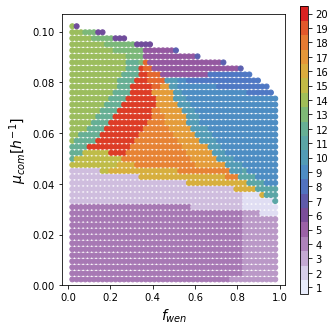

In [8]:
#plot single
case = filtered_cases[0] #selection of case
fig, ax = plt.subplots(1, 1, figsize=(4*1, 5), sharey=True, sharex = True)

model = copy.deepcopy(master_cases[case])
name_community_model, name_scenario = case.split('_sce_')
#title for plot
change_case = case.split(case.split('_')[-3])[1][1:]
name_scenario = name_scenario.split('_',2)
sim_params = simulations.loc[simulations['Filename'] == case]

plt.rcParams.update({'font.size': 10})

parent_cmap = 'rainbow_WhRd' #'tab20'
x, y, c, cmap1, vmin, vmax, s = pre_plot_clusters(model, parent_cmap)       
        
cmaplist = [cmap1(i) for i in range(cmap1.N)]
# create the new map
cmap1 = mpl.colors.LinearSegmentedColormap.from_list(
            'Custom cmap', cmaplist, cmap1.N)

        # define the bins and normalize
bounds = np.linspace(1, max(model.clusters)+1, max(model.clusters)+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap1.N)
tick_locs = (np.arange(params['k']+1) + 0.5)
s=25

im = ax.scatter(x,y, c = c,cmap=cmap1, s=s,vmin=vmin,vmax=vmax)
  
ymin, ymax = plt.ylim()
plt.ylim([0,ymax])
plt.xlabel('$f_{wen}$', fontsize = 14)
plt.ylabel('$\mu_{com}[h^{-1}]$', fontsize=14)
# create a second axes for the colorbar
ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap1, norm=norm,
            spacing='uniform', ticks=tick_locs, format="%d")

#plt.tight_layout()
#plt.savefig('clusters.pdf',  bbox_inches='tight')   

Plot distribution of flux values for a specific reaction

Text(-0.1, 0.5, '$\\mu_{com}[h^{-1}]$')

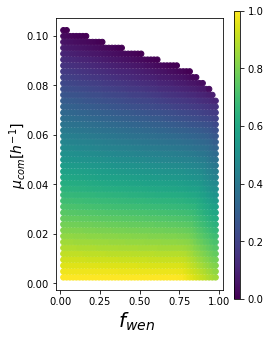

In [9]:
r = 'EX_eps_AFE_e'
c=model.qual_vector_df[r]
x = model.points[c.index,0]
y = model.points[c.index,1]
fva_reaction =model.fva_results[:,4,1]
fig, ax = plt.subplots(1, 1, figsize=(3, 5), sharey=True, sharex = True)
ax.scatter(x,y, c = fva_reaction, s=30)
ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
mpl.colorbar.ColorbarBase(ax2)
fig.text(0.5, 0.02, '$f_{wen}$', ha='center', fontsize=20)
fig.text(-0.1, 0.5, '$\mu_{com}[h^{-1}]$', va='center', rotation='vertical', fontsize=14)
#plt.savefig('EPSprod09.pdf', bbox_inches='tight')

# Overlap of qualitative states

The function plot_multiple_overlap is performed to analyze the overlap of qualitative states on different scenarios. It can be performed with a single reaction as well as with multiple reactions to analyze their distribution in the abundance growth space.

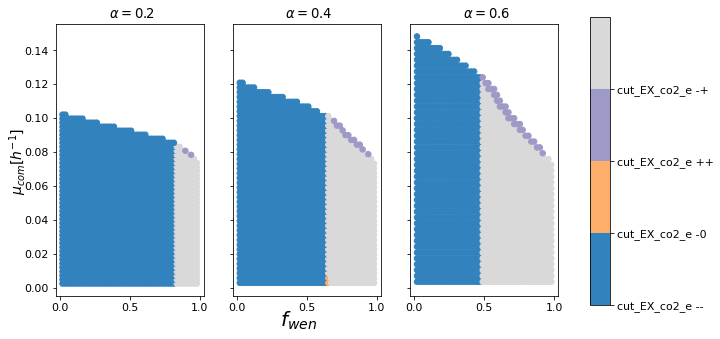

In [21]:
rxns = ['cut_EX_co2_e']
plot_multiple_overlap(filtered_cases, master_cases, params, rxns, cmap_name = None, status_dict=None, base = 10, colorbar=True, filename = None)
    

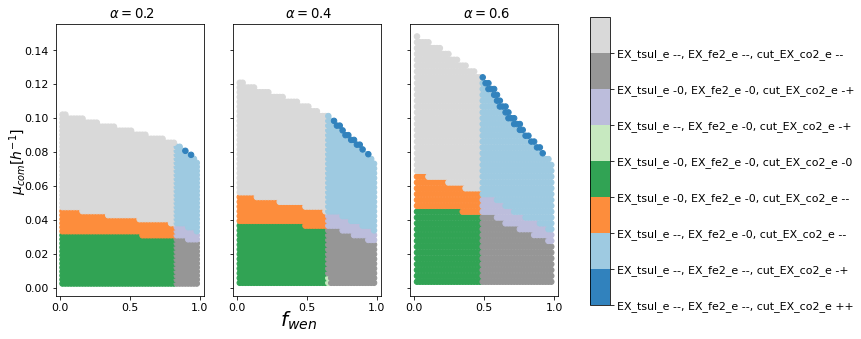

In [22]:
rxns = ['cut_EX_co2_e', 'EX_fe2_e', 'EX_tsul_e']
plot_multiple_overlap(filtered_cases, master_cases, params, rxns, cmap_name = None, status_dict=None, base = 10, colorbar=True, filename = None)
    

# Clustering analysis

In [11]:
#Select case to be analyzed
case = filtered_cases[0]
model = copy.deepcopy(master_cases[case])
print(case)

biomin_newgrid_sce_a02_biocons_75Fe_5S


## Key reaction candidates

A table is constructed for the reactions which qualitative values change on the abundance growth space. A threshold is setted to compute the consensus value for each cluster. Presented reactions exhibit changes on the grid and are candidates for being key reactions of the analyzed scenario.

The function **compare_clusters** allow to compare which reactions change between two clusters

In [12]:
df = model.get_cluster_reaction_values(thr=0.8, changing= True)

In [13]:
df

,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17,c18,c19,c20
EX_eps_AFE_e,0+,0+,0+,0+,0+,0+,NaN,0+,0+,0+,0+,0+,0+,0+,0+,0+,0+,0+,0+,0+
EX_fe2_e,-0,-0,-0,-0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
EX_fe3_e,0+,0+,0+,0+,++,++,++,++,++,++,++,++,++,++,++,++,++,++,++,++
EX_glc_pool,0+,0+,0+,0+,0+,0+,NaN,0+,0+,0+,0+,0+,0+,0+,0+,0+,0+,0+,0+,0+
EX_h_e,-+,-+,-+,-+,--,--,--,--,--,--,-+,--,--,--,-+,-+,--,NaN,--,--
EX_nh4_e,--,--,--,--,--,NaN,-,--,--,--,--,--,--,--,--,--,--,--,--,--
EX_so4_e,0+,0+,0+,0+,++,++,++,++,++,++,NaN,++,++,++,NaN,0+,++,++,++,++
EX_succ_c,0+,0+,0+,0+,0+,0+,NaN,0+,0+,0+,0+,0+,0+,0+,0+,0+,0+,0+,0+,0+
EX_tsul_e,--,--,-0,-0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
cut_EX_co2_e,-+,--,-+,--,--,--,--,NaN,NaN,--,-+,--,--,--,--,--,--,--,--,--


In [14]:
model.compare_clusters(df, 'c5','c4')

,c5,c4
EX_fe2_e,--,-0
EX_fe3_e,++,0+
EX_h_e,--,-+
EX_so4_e,++,0+
EX_tsul_e,--,-0
cut_EX_glc_e,--,-0
cut_EX_so4_e,++,0+
cut_EX_tsul_e,--,-0
wen_EX_fe2_e,--,-0
wen_EX_fe3_e,++,0+


## Cluster descriptors

The function **get_cluster_descriptor** allows to show which reaction status are more descriptive of each cluster on the grid. To compute this each reaction status is compared with the rest of the clusters and a diff value (that shows how different to the state of the other clusters) is computed.

In [19]:
get_cluster_descriptor(model, 'c14')

,status c14,diff
cut_EX_h_e,--,17.0
cut_EX_h2o_e,++,17.0
cut_EX_fe2_e,--,16.0
cut_EX_fe3_e,++,16.0
cut_EX_so4_e,++,13.0
wen_EX_tsul_e,-0,12.0
cut_EX_tsul_e,--,11.0
wen_EX_so4_e,0+,10.0
EX_h_e,--,8.0
EX_so4_e,++,7.0
